In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import tqdm
import os

%matplotlib notebook

D:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Device Configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# Hyper-parameters 
num_epochs = 300
batch_size = 32
learning_rate = 0.001

In [4]:
class CustomDataset(Dataset):
    def __init__(self, csv_path):
        # Load your data from CSV file
        self.data = pd.read_csv(csv_path)
        self.length = len(self.data)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        # Load and preprocess the data at the given index
        sample = self.data.iloc[index]
#       Extract features and labels
#         features = torch.tensor(np.reshape(np.correlate(sample.iloc[0:4095].values, [0.05]*20, 'same'), (1, 4095)), dtype=torch.float32)  # Adjust based on your column names
        features = torch.tensor(np.reshape(sample.iloc[0:4095].values, (1, 4095)), dtype=torch.float32)
#         label = torch.tensor(sample[['y0', 'y1']].values, dtype=torch.float32) 
        label = torch.tensor(np.asarray([sample['y0'], sample['y1']*100]), dtype=torch.float32)

        return features, label

#### Reading Data

In [5]:
dataset = CustomDataset('./data/merged_data_wavelet.csv')
train_data, val_data = train_test_split(dataset, test_size=0.2)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
# val_loader = dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
val_loader = dataloader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=False)

In [6]:
for batch_idx, (features, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1} - Features: {features.shape}, Labels: {labels.shape}")
    print("First few elements of features:")
    print(features[:5])
    print("First few elements of labels:")
    print(labels)

    if batch_idx == 0:
        break

Batch 1 - Features: torch.Size([32, 1, 4095]), Labels: torch.Size([32, 2])
First few elements of features:
tensor([[[0.1090, 0.1090, 0.1090,  ..., 0.0619, 0.0618, 0.0618]],

        [[0.1020, 0.1020, 0.1020,  ..., 0.0597, 0.0598, 0.0598]],

        [[0.1010, 0.1010, 0.1010,  ..., 0.0596, 0.0596, 0.0596]],

        [[0.1060, 0.1060, 0.1060,  ..., 0.0622, 0.0622, 0.0622]],

        [[0.1130, 0.1130, 0.1130,  ..., 0.0611, 0.0611, 0.0611]]])
First few elements of labels:
tensor([[ 942.0000,    8.1000],
        [1021.0000,    7.4000],
        [1015.0000,    9.8000],
        [ 962.0000,    4.8000],
        [ 892.0000,    6.2000],
        [ 955.0000,    4.9000],
        [ 952.0000,    4.6000],
        [1032.0000,   11.5000],
        [ 876.0000,    5.9000],
        [1066.0000,    3.9000],
        [ 883.0000,    5.9000],
        [ 890.0000,    7.3000],
        [ 937.0000,    5.2000],
        [ 957.0000,   10.5000],
        [1057.0000,    4.6000],
        [ 943.0000,    4.9000],
        [1030.00

In [7]:
# # # # To determine the input size of fully connected layer
dataiter = iter(train_loader)
images, labels = next(dataiter)

conv1 = nn.Conv1d(1, 32, 8)
bn1 = nn.BatchNorm1d(32)
pool1 = nn.MaxPool1d(4)
conv2 = nn.Conv1d(32, 64, kernel_size=6)
pool2 = nn.MaxPool1d(4)
conv3 = nn.Conv1d(64,64,kernel_size=3)
print(images.shape)
y = conv1(images)
print(y.shape)
y = pool1(y)
print(y.shape)
y = conv2(y)
print(y.shape)
y = pool2(y)
print(y.shape)
y = conv3(y)
print(y.shape)

# x = F.relu(conv1(images))
# x = pool1(x)

# x = F.relu(conv2(x))
# x = pool2(x)

# x = F.relu(conv3(x))
# print(x.shape)

torch.Size([32, 1, 4095])
torch.Size([32, 32, 4088])
torch.Size([32, 32, 1022])
torch.Size([32, 64, 1017])
torch.Size([32, 64, 254])
torch.Size([32, 64, 252])


#### Model

In [8]:
class RegressionCNN(nn.Module):
    def __init__(self):
        super(RegressionCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(1, 32, 8)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(4)
        
        self.conv2 = nn.Conv1d(32,64,6)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(4)
        
        self.conv3 = nn.Conv1d(64,64,3)
        self.bn3 = nn.BatchNorm1d(64)
        
#         self.fc1 = nn.Linear(64*252, 512)  # Adjust input size based on your data
#         self.fc2 = nn.Linear(512, 256)
#         self.fc3 = nn.Linear(256, 2)  # 2 output values for regression

        self.fc1 = nn.Linear(64*252, 256)  # Adjust input size based on your data
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512,128)
        self.fc4 = nn.Linear(128, 2)  # 2 output values for regression

    def forward(self, x):
        # Convolutional layers with batch normalization and ReLU activation
#         x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
#         x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
#         x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.conv3(x))
        
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#         x = self.fc3(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x


In [9]:
# Instantiate the model
model = RegressionCNN().to(device)

# Print the model architecture
print(model)

RegressionCNN(
  (conv1): Conv1d(1, 32, kernel_size=(8,), stride=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(6,), stride=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
)


In [10]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [11]:
model = RegressionCNN().to(device)

In [12]:
# Loss Function
#-----------------------------------------------------
# criterion = nn.MSELoss()
criterion = RMSLELoss()
criterion_MAE = nn.L1Loss()

# Optimizer
#-----------------------------------------------------
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00007)

# Scheduler
#-----------------------------------------------------
# scheduler = ExponentialLR(optimizer, gamma = 0.1)
# scheduler = StepLR(optimizer, step_size = 4, gamma = 0.5)

In [13]:
# Initialize variable to track loss and accuracies for each epochs
# torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

y_loss = {} 
y_loss['train'] = []
y_loss['val'] = []

y_loss_ramp_voltage = {}
y_loss_ramp_voltage['train'] = []
y_loss_ramp_voltage['val'] = []

y_loss_pddiff_voltage = {}
y_loss_pddiff_voltage['train'] = []
y_loss_pddiff_voltage['val'] = []

x_epoch = []



n_total_steps = len(train_loader)
dataset_sizes = {'train': len(train_loader), 'val': len(val_loader)}

num_epochs = 3310

for epoch in tqdm.tqdm(range(num_epochs)):
    model.train()
    
    
    total_loss = 0.0
    
    pdloss_train = 0.0
    pdloss_val = 0.0
    
    ramploss_train = 0.0
    ramploss_val = 0.0
    

    for inputs, targets in train_loader:
#         # Zero the gradients
#         optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs.to(device))

        # Compute the loss
        loss = criterion(outputs, targets.to(device))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
#         print(outputs[:,0])
        pdloss_train+= criterion_MAE(outputs[:,1]/100, targets[:,1].to(device)/100).item()
#         pdloss_train+= torch.div(criterion_MAE(outputs[:,1]/100, targets[:,1].to(device)/100).item(),targets[:,1].to(device)).item()
        ramploss_train+= criterion_MAE(outputs[:,0], targets[:,0].to(device)).item()


    # Calculate average training loss
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs.to(device))
            val_loss += criterion(val_outputs, val_targets.to(device)).item()
#             pdloss_val+= criterion_MAE(val_outputs[:,1]/100, val_targets[:,1].to(device)/100).item()
#             pdloss_val+= torch.div(criterion_MAE(val_outputs[:,1]/100, val_targets[:,1].to(device)/100).item(), val_targets[:,1].to(device)).item()
            pdloss_val+= criterion_MAE(torch.div(val_outputs[:,1].to(device),val_targets[:,1].to(device)), torch.ones_like(val_targets[:,1]).to(device)).item()
            ramploss_val+= criterion_MAE(val_outputs[:,0], val_targets[:,0].to(device)).item()

    # Calculate average validation loss
    average_val_loss = val_loss / len(val_loader)
    
    y_loss['train'].append(average_loss)
    y_loss['val'].append(average_val_loss)
    
    y_loss_pddiff_voltage['train'].append(pdloss_train/len(train_loader))
    y_loss_pddiff_voltage['val'].append(pdloss_val/len(val_loader))
    
    y_loss_ramp_voltage['train'].append(ramploss_train/len(train_loader))
    y_loss_ramp_voltage['val'].append(ramploss_val/len(val_loader))
    

#     print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}')


with torch.no_grad():
    for val_inputs, val_targets in val_loader:
        val_outputs = model(val_inputs.to(device))
        print(val_outputs)
        print(val_targets.to(device))
        break

100%|██████████████████████████████████████████████████████████| 3310/3310 [04:31<00:00, 12.21it/s]

tensor([[1004.4147,   10.6263]], device='cuda:0')
tensor([[1002.0000,   10.1000]], device='cuda:0')


In [15]:
pdloss_val = 0.0
with torch.no_grad():
    for val_inputs, val_targets in val_loader:
        print(val_inputs.shape, val_inputs[0].shape)
        val_outputs = model(val_inputs.to(device))
#         print(model(val_inputs[0].to(device)))
        print(criterion_MAE(torch.div(val_outputs[:,1].to(device),val_targets[:,1].to(device)), torch.ones_like(val_targets[:,1]).to(device)).item())
#         print(val_outputs[0][0].to('cpu'))
#         print(val_targets.to(device))
        break

torch.Size([1, 1, 4095]) torch.Size([1, 4095])
0.05210590362548828


<IPython.core.display.Javascript object>


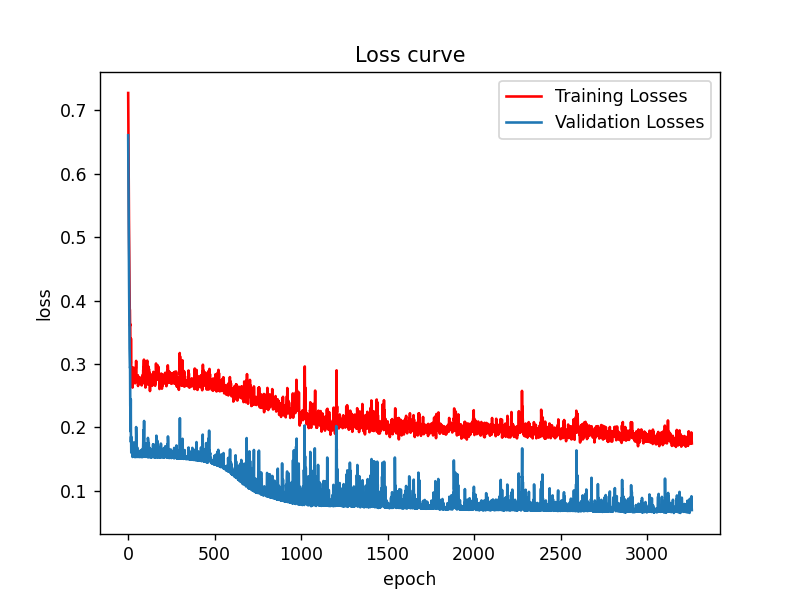

In [22]:
# Plot Loss curve
plt.close()
plt.plot(y_loss['train'][50:], "-r", label = "Training Losses")
plt.plot(y_loss['val'][50:], label = "Validation Losses")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss curve")
plt.legend()
plt.show()
# plt.savefig("./img/b"+str(batch_size)+"_lr"+str(learning_rate)+"_epoch"+str(num_epochs)+"_Loss_sgd.png")

<IPython.core.display.Javascript object>


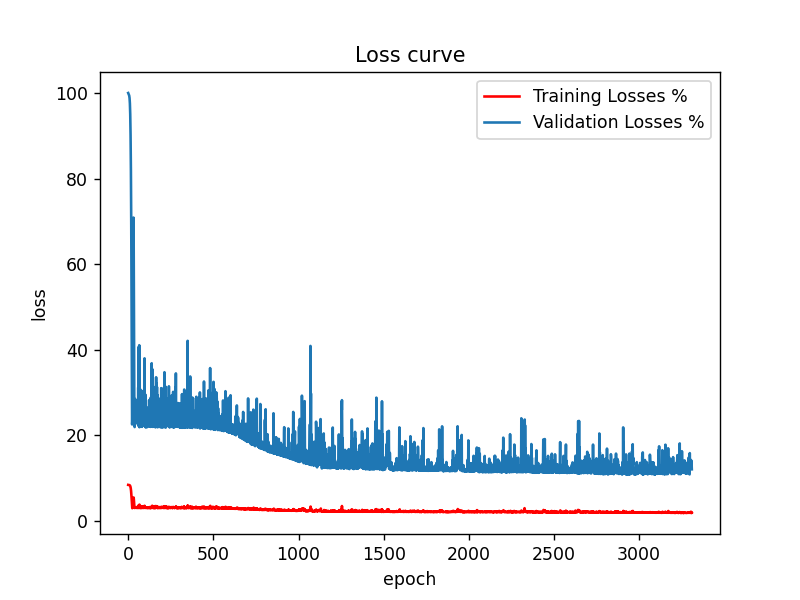

In [23]:
# Plot Loss curve
plt.close()
plt.plot(np.asarray(y_loss_pddiff_voltage['train'])*100, "-r", label = "Training Losses %")
plt.plot(np.asarray(y_loss_pddiff_voltage['val'])*100, label = "Validation Losses %")

# plt.plot(y_loss['val'][50:], label = "Validation Losses")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss curve")
plt.legend()
plt.show()
# plt.savefig("./img/b"+str(batch_size)+"_lr"+str(learning_rate)+"_epoch"+str(num_epochs)+"_Loss_sgd.png")

<IPython.core.display.Javascript object>


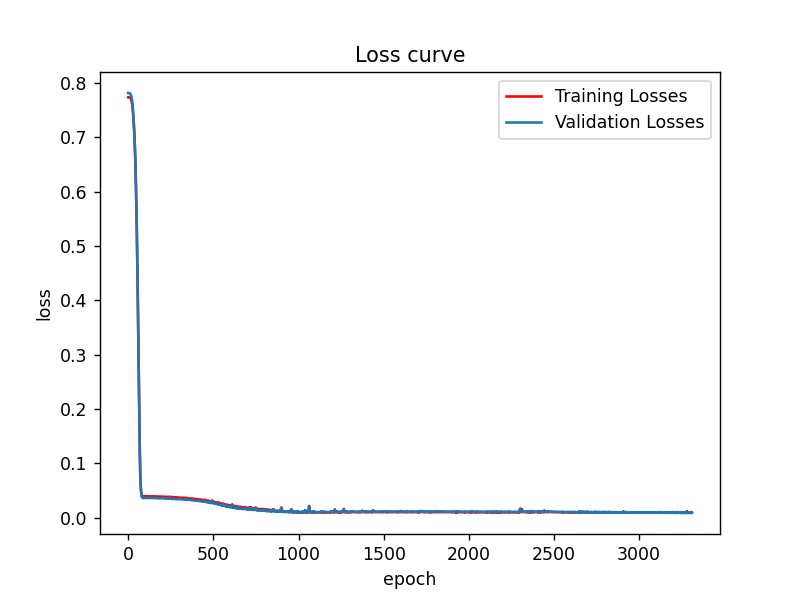

In [17]:
# Plot Loss curve
plt.close()
plt.plot(np.asarray(y_loss_ramp_voltage['train'])/4095*3.3, "-r", label = "Training Losses")
plt.plot(np.asarray(y_loss_ramp_voltage['val'])/4095*3.3, label = "Validation Losses")

# plt.plot(y_loss['val'][50:], label = "Validation Losses")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss curve")
plt.legend()
plt.show()
# plt.savefig("./img/b"+str(batch_size)+"_lr"+str(learning_rate)+"_epoch"+str(num_epochs)+"_Loss_sgd.png")

In [16]:
import torch.onnx

In [17]:
dummy_input = torch.randn(1, 1, 4095)

# Export the model to ONNX
onnx_path = "model.onnx"
torch.onnx.export(model, dummy_input.to(device), onnx_path, verbose=True, input_names=['input'], output_names=['output'])

In [18]:
print(dummy_input.shape)

torch.Size([1, 1, 4095])


In [19]:
import torch.onnx
import onnx
import onnxruntime

onnx_path = "model.onnx"

onnx_model = onnx.load(onnx_path)

onnx.checker.check_model(onnx_model)
print("ONNX model is valid.")
ort_session = onnxruntime.InferenceSession(onnx_path)

print("Input nodes:", ort_session.get_inputs())
print("Output nodes:", ort_session.get_outputs())

# Prepare a dummy input tensor (replace with actual input)
# dummy_input = torch.randn(1, 3, 224, 224)

ONNX model is valid.
Input nodes: [<onnxruntime.capi.onnxruntime_pybind11_state.NodeArg object at 0x000001E53AFE7130>]
Output nodes: [<onnxruntime.capi.onnxruntime_pybind11_state.NodeArg object at 0x000001E5CD7A8A30>]


In [20]:
dummy_input = None
temp = None
with torch.no_grad():
    for val_inputs, val_targets in val_loader:
#         print(val_inputs[23])
        dummy_input = val_inputs
        val_outputs = model(val_inputs.to(device))
        temp = val_inputs
#         print(val_targets[:,1])
        print(criterion_MAE(torch.div(val_outputs[:,1].to(device),val_targets[:,1].to(device)), torch.ones_like(val_targets[:,1]).to(device)).item())
#         print(val_outputs[0][0].to('cpu'))
#         print(val_targets.to(device))
        break
print(model(val_inputs.to(device)))
# model.train()
# print(model(dummy_input.to(device)))

0.05210590362548828
tensor([[1004.4147,   10.6263]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [21]:
# Convert the dummy input to a NumPy array and perform inference
input_numpy = dummy_input.numpy()
output = ort_session.run(None, {"input": input_numpy})

# Print the inference result
print("Inference result:", output)

Inference result: [array([[1004.4146  ,   10.626269]], dtype=float32)]


In [36]:
from onnx import shape_inference

In [37]:
onnx_model = onnx.load("model.onnx")
inferred_model = shape_inference.infer_shapes(onnx_model)
print(inferred_model)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:


# # start
# start = time.time()
# for epoch in tqdm.tqdm(range(num_epochs)):
#     for phase in ['train', 'val']:        
#         running_loss = 0.0
#         running_corrects = 0.0
#         count = 0
#         total = 0
#         if(phase == 'train'):
#             for images, labels in train_loader:
#                 images = images.to(device)
#                 labels = labels.to(device)
        
#                 # Forward pass
#                 outputs = model(images)
#                 _, preds = torch.max(outputs.data, 1)
#                 loss = criterion(outputs, labels)

#                 # Backward and optimize
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#                 # the class with the highest energy is what we choose as prediction        
#                 running_loss += loss.item()              
#                 total += labels.size(0)
#                 running_corrects += (preds == labels).sum().item()
        
#             epoch_loss = running_loss / total
#             epoch_acc = running_corrects / total
# #             if (i+1) % 20 == 0:
# #             print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

#             y_loss[phase].append(epoch_loss)
#             y_err[phase].append(1.0 - epoch_acc)
# #             scheduler.step()

            
#         elif(phase == 'val'):
#             for i, (images, labels) in enumerate(val_loader):
#                 images = images.to(device)
#                 labels = labels.to(device)

#                 # Forward pass
#                 outputs = model(images)
#                 _, preds = torch.max(outputs.data, 1)
#                 loss = criterion(outputs, labels)
                
#                 # the class with the highest energy is what we choose as prediction
#                 running_loss += loss.item()              
#                 total += labels.size(0)
#                 running_corrects += (preds == labels).sum().item()               
                
#             epoch_loss = running_loss / total
#             epoch_acc = running_corrects / total
# #             if (i+1) % 200 == 0:
# #             print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

#             y_loss[phase].append(epoch_loss)
#             y_err[phase].append(1.0 - epoch_acc)

#             x_epoch.append(epoch)  
            
# print(f'training time: {(time.time()-start)} sec')
# # end